C:\Users\HChen8\AppData\Local\Temp\ipykernel_43808\749169218.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


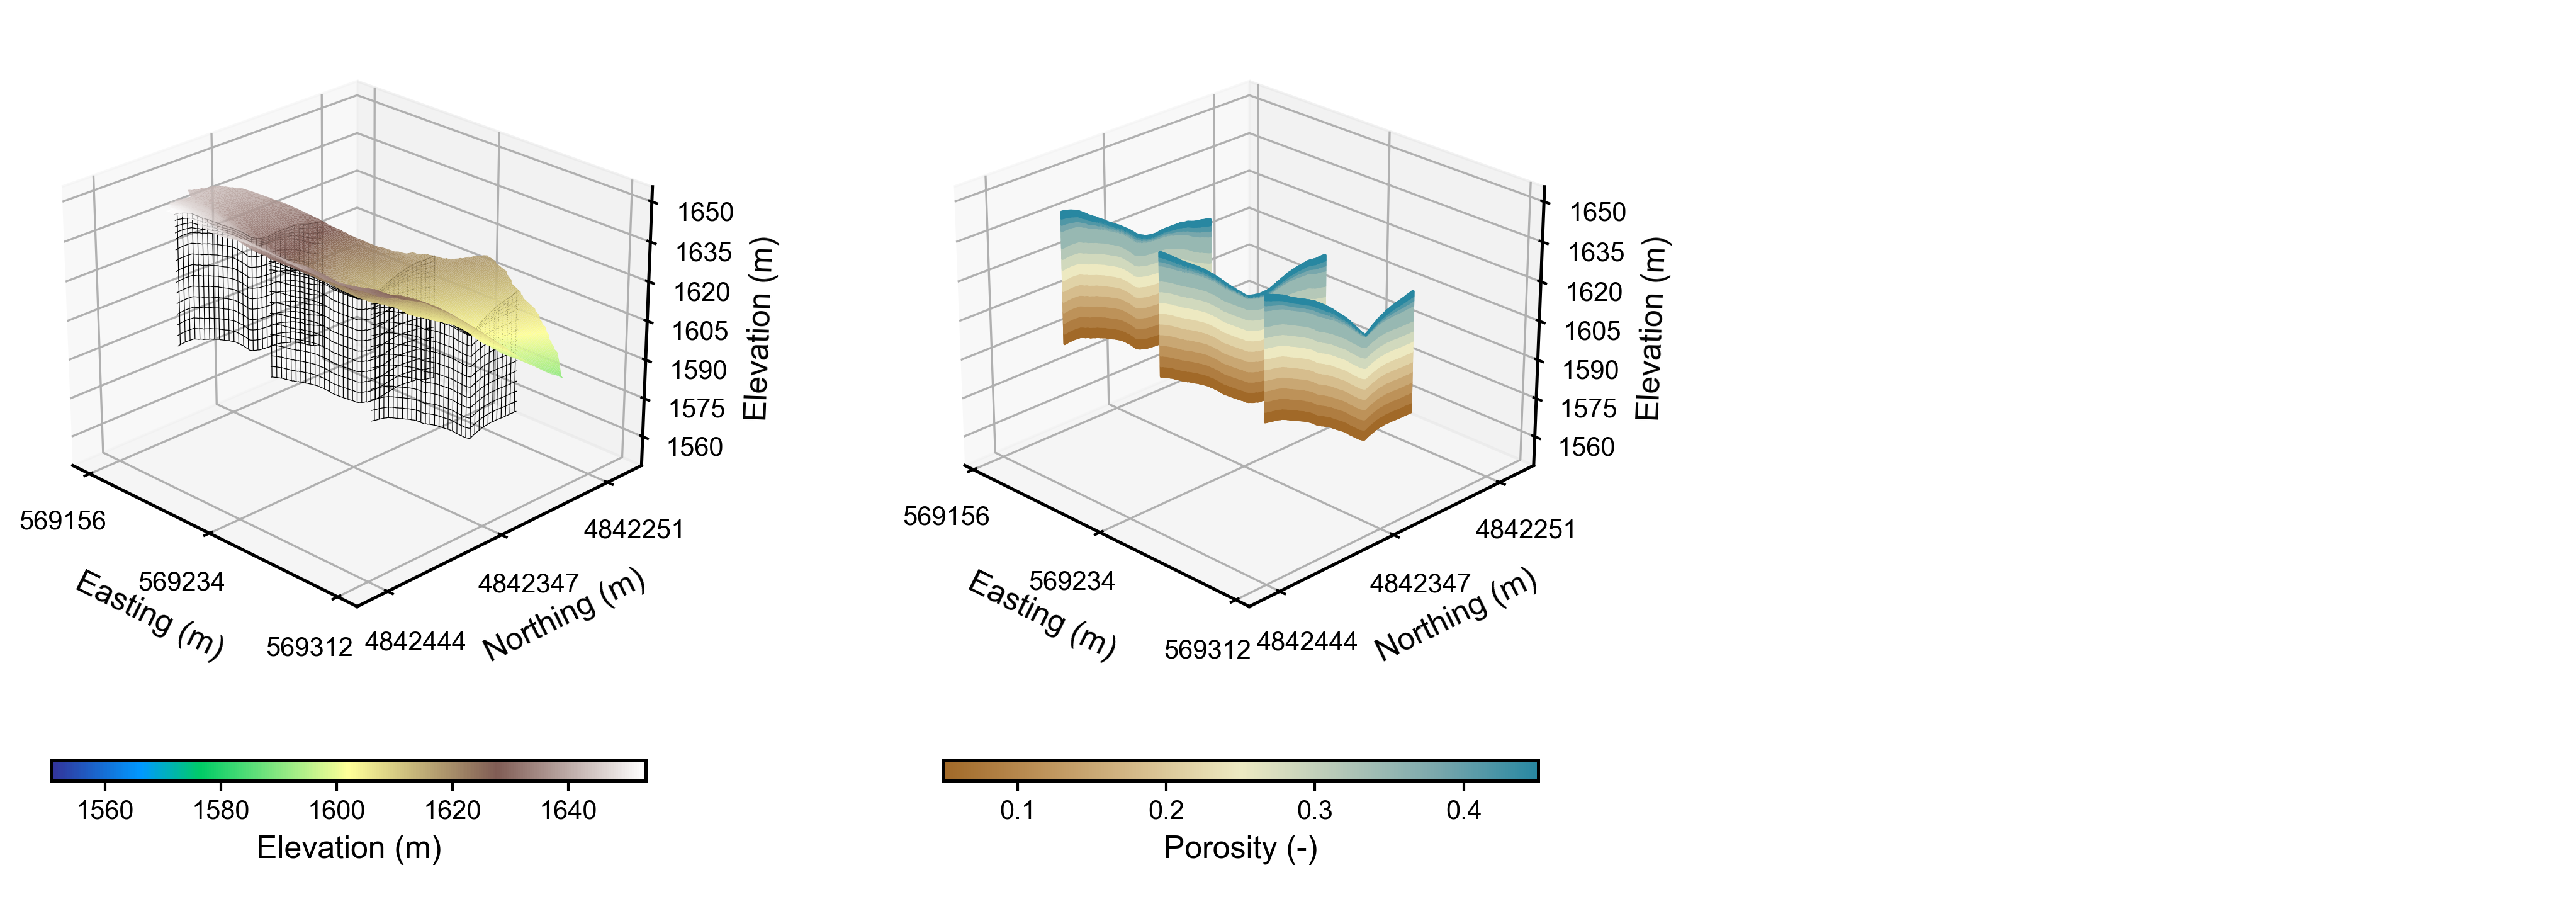

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from palettable.cartocolors.diverging import Earth_7
ctcolor = Earth_7.mpl_colormap

# ─── 1) Publication‐quality defaults ─────────────────────────────────────────
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.linewidth': 1.2,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.minor.size': 2,
    'ytick.minor.size': 2,
    'figure.dpi': 300,
    'figure.facecolor': 'white'
})

# ─── 2) Load data ─────────────────────────────────────────────────────────────
data_dir   = "data/"
top        = np.loadtxt(os.path.join(data_dir, "top.txt"))
idom       = np.loadtxt(os.path.join(data_dir, "id.txt"))
porosity   = np.load(  os.path.join(data_dir, "Porosity.npy"))
bot        = np.load(  os.path.join(data_dir, "bot.npy"))

# your georeferencing
origin_x    = 569156.2983333333
origin_y    = 4842444.17
pixel_width = 1.0
pixel_height= -1.0

# mask inactive
top[idom == 0] = np.nan

ny, nx = top.shape

# tick indices we want
ix = np.array([0, nx//2, nx-1])
iy = np.array([0, ny//2, ny-1])

# convert to real coords
x_ticks = (origin_x + ix * pixel_width).astype(int)
y_ticks = (origin_y + iy * pixel_height).astype(int)

# meshgrid in pixel‐space
X_idx, Y_idx = np.meshgrid(np.arange(nx), np.arange(ny))

is_multi = (bot.ndim == 3)
nlayers  = bot.shape[0] if is_multi else 1

# global z limits
zmin_glob = min(np.nanmin(top), np.nanmin(bot))
zmax_glob = np.nanmax(top)

elev_norm = Normalize(vmin=zmin_glob, vmax=zmax_glob)

# choose slices
slice_xs = [nx//4, nx//2, 3*nx//4]

# build wire‐frame grids
slice_grids = {}
for sx in slice_xs:
    if 0 <= sx < nx:
        y_len = min(ny, bot.shape[1] if is_multi else bot.shape[0])
        ys    = np.arange(y_len)
        top_p = top[:y_len, sx]
        bots  = [bot[L, :y_len, sx] for L in range(nlayers)] if is_multi else [bot[:y_len, sx]]
        Zg    = np.vstack([top_p] + bots)
        Yg    = np.tile(ys, (Zg.shape[0],1))
        Xg    = np.full_like(Yg, sx)
        slice_grids[sx] = (Xg, Yg, Zg)

# ─── 3) Plot ──────────────────────────────────────────────────────────────────
fig = plt.figure(figsize=(18, 6))
gs  = gridspec.GridSpec(1, 3, wspace=0.05)

# Panel A: Topography
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.set_xticks(ix);  ax1.set_xticklabels(x_ticks)
ax1.set_yticks(iy);  ax1.set_yticklabels(y_ticks)
ax1.set_zticks(np.linspace(zmin_glob, zmax_glob, 5).astype(int))
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')
ax1.set_zlabel('Elevation (m)')
ax1.set_zlim(zmin_glob, zmax_glob)
ax1.zaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_ylim([-20,220])
ax1.set_ylim([-20,220])
# surface
ax1.plot_surface(
    X_idx, Y_idx, top,
    cmap='terrain', norm=elev_norm,
    rstride=1, cstride=1,
    linewidth=0, antialiased=True, shade=True
)

# colorbar horizontal
sm1 = plt.cm.ScalarMappable(cmap='terrain', norm=elev_norm)
sm1.set_array([])
fig.colorbar(
    sm1, ax=ax1,
    orientation='horizontal',
    pad=0.12, shrink=0.7, aspect=30
).set_label('Elevation (m)')

# wire‐frames
for Xg, Yg, Zg in slice_grids.values():
    ax1.plot_wireframe(Xg, Yg, Zg, color='black', linewidth=0.3)

ax1.view_init(elev=25, azim=-45)


# Panel B: Porosity
ax2 = fig.add_subplot(gs[1], projection='3d')
ax2.set_xticks(ix);  ax2.set_xticklabels(x_ticks)
ax2.set_yticks(iy);  ax2.set_yticklabels(y_ticks)
ax2.set_zticks(np.linspace(zmin_glob, zmax_glob, 5).astype(int))
ax2.set_xlabel('Easting (m)')
ax2.set_ylabel('Northing (m)')
ax2.set_zlabel('Elevation (m)')
ax2.set_zlim(zmin_glob, zmax_glob)
ax2.set_ylim([-20,220])
ax2.set_xlim([-2,160])
ax2.zaxis.set_major_locator(MaxNLocator(integer=True))

# porosity norm
all_p = []
if porosity.ndim==3:
    for L in range(porosity.shape[0]):
        all_p.append(porosity[L][~np.isnan(porosity[L])])
else:
    all_p.append(porosity[~np.isnan(porosity)])
por_norm = Normalize(vmin=np.min(np.concatenate(all_p)), vmax=np.max(np.concatenate(all_p)))

# plot porosity slices + wires
for Xg, Yg, Zg in slice_grids.values():
    depth_lv, y_len = Zg.shape
    Por = np.zeros_like(Zg)
    if porosity.ndim==3:
        for L in range(porosity.shape[0]):
            row = porosity[L, :y_len, Xg[0,0]]
            lvl = min(int(L*depth_lv/porosity.shape[0]), depth_lv-1)
            Por[lvl] = row
    else:
        row = porosity[:y_len, Xg[0,0]]
        Por = np.tile(row, (depth_lv,1))

    ax2.plot_surface(
        Xg, Yg, Zg,
        facecolors=ctcolor(por_norm(Por)),
        rstride=1, cstride=1,
        antialiased=True, shade=False
    )
    ax2.plot_wireframe(Xg, Yg, Zg, color='black', linewidth=0.3)

# horizontal porosity cb
sm2 = plt.cm.ScalarMappable(cmap=ctcolor, norm=por_norm)
sm2.set_array([])
fig.colorbar(
    sm2, ax=ax2,
    orientation='horizontal',
    pad=0.12, shrink=0.7, aspect=30
).set_label('Porosity (-)')

ax2.view_init(elev=25, azim=-45)

ax3 = fig.add_subplot(gs[2], projection='3d')
ax3.set_axis_off()
plt.tight_layout()
plt.savefig('final_subsurface.tiff', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
x_ticks

array([569156, 569234, 569312])